In [4]:
import os
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import sys
sys.path.append("../src")
from main_pipeline import load_models, analyze_image, visualize_results

# --- AYARLAR ---
BASE_DIR = ".." # Eğer src içindeysek bir üst dizine çık
TEST_IMG_DIR = os.path.join(BASE_DIR, "data/raw/test/disease/input")
TEST_LBL_DIR = os.path.join(BASE_DIR, "data/raw/test/disease/label")

# Dentex JSON ID Haritası (Ground Truth çizimi için)
DISEASE_MAP = {
    0: "Healthy",          # Train analizinde ID 0 Healthy (veya Impacted?) çıkmıştı, kontrol et!
    1: "Impacted",         # Genelde en çok olan
    2: "Caries",
    3: "Periapical_Lesion",
    4: "Deep_Caries"       # Bazen 4 olabilir
}

# Modelleri Yükle (Sadece 1 kere)
ai_models = load_models()

print(f"📂 Test Klasörü: {TEST_IMG_DIR}")

📂 Test Klasörü: ../data/raw/test/disease/input


In [ ]:
def draw_ground_truth(image_path, json_path):
    img = cv2.imread(image_path)
    if img is None: return None
    
    if not os.path.exists(json_path):
        return img

    with open(json_path, 'r') as f:
        data = json.load(f)

    # 1. LabelMe Formatı Kontrolü ("shapes" var mı?)
    shapes = data.get('shapes', [])
    
    # Eğer shapes yoksa eski usül annotations (COCO) deneyelim (Fallback)
    if not shapes and 'annotations' in data:
        # Burası eski kodun yedeği olur, ama senin durumda shapes çalışacak.
        pass 

    for shape in shapes:
        label_raw = shape.get('label', '') # Örn: "3-kanal-36"
        points = shape.get('points', [])   # [[x1,y1], [x2,y2], ...]
        
        if not points: continue

        # 2. Etiketi Parse Etme (Baştaki sayıyı yakala)
        # "3-kanal-36" -> 3'ü bul.
        class_id = None
        try:
            # Tireden önceki ilk kısmı al, sayıya çevir
            first_part = label_raw.split('-')[0]
            class_id = int(first_part)
        except:
            # Sayı ile başlamıyorsa, kelime bazlı kontrol (Opsiyonel)
            if "caries" in label_raw.lower(): class_id = 2
            elif "impacted" in label_raw.lower(): class_id = 1
            pass

        if class_id in DISEASE_MAP:
            d_name = DISEASE_MAP[class_id]
            
            # 4. Polygon'dan BBox 
            np_points = np.array(points, dtype=np.int32)
            
            x_min = np.min(np_points[:, 0])
            y_min = np.min(np_points[:, 1])
            x_max = np.max(np_points[:, 0])
            y_max = np.max(np_points[:, 1])
            
            # 5. Çizim (Yeşil Kutu - Ground Truth)
            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            
            # Etiket: "GT: Periapical_Lesion"
            label_text = f"GT: {d_name}"
            cv2.putText(img, label_text, (x_min, y_min - 5), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        else:
            
            print(f"⚠️ Tanınmayan Etiket: {label_raw}")
            pass
            
    return img

def show_img(img, title=""):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')

Toplam 250 adet test resmi var.


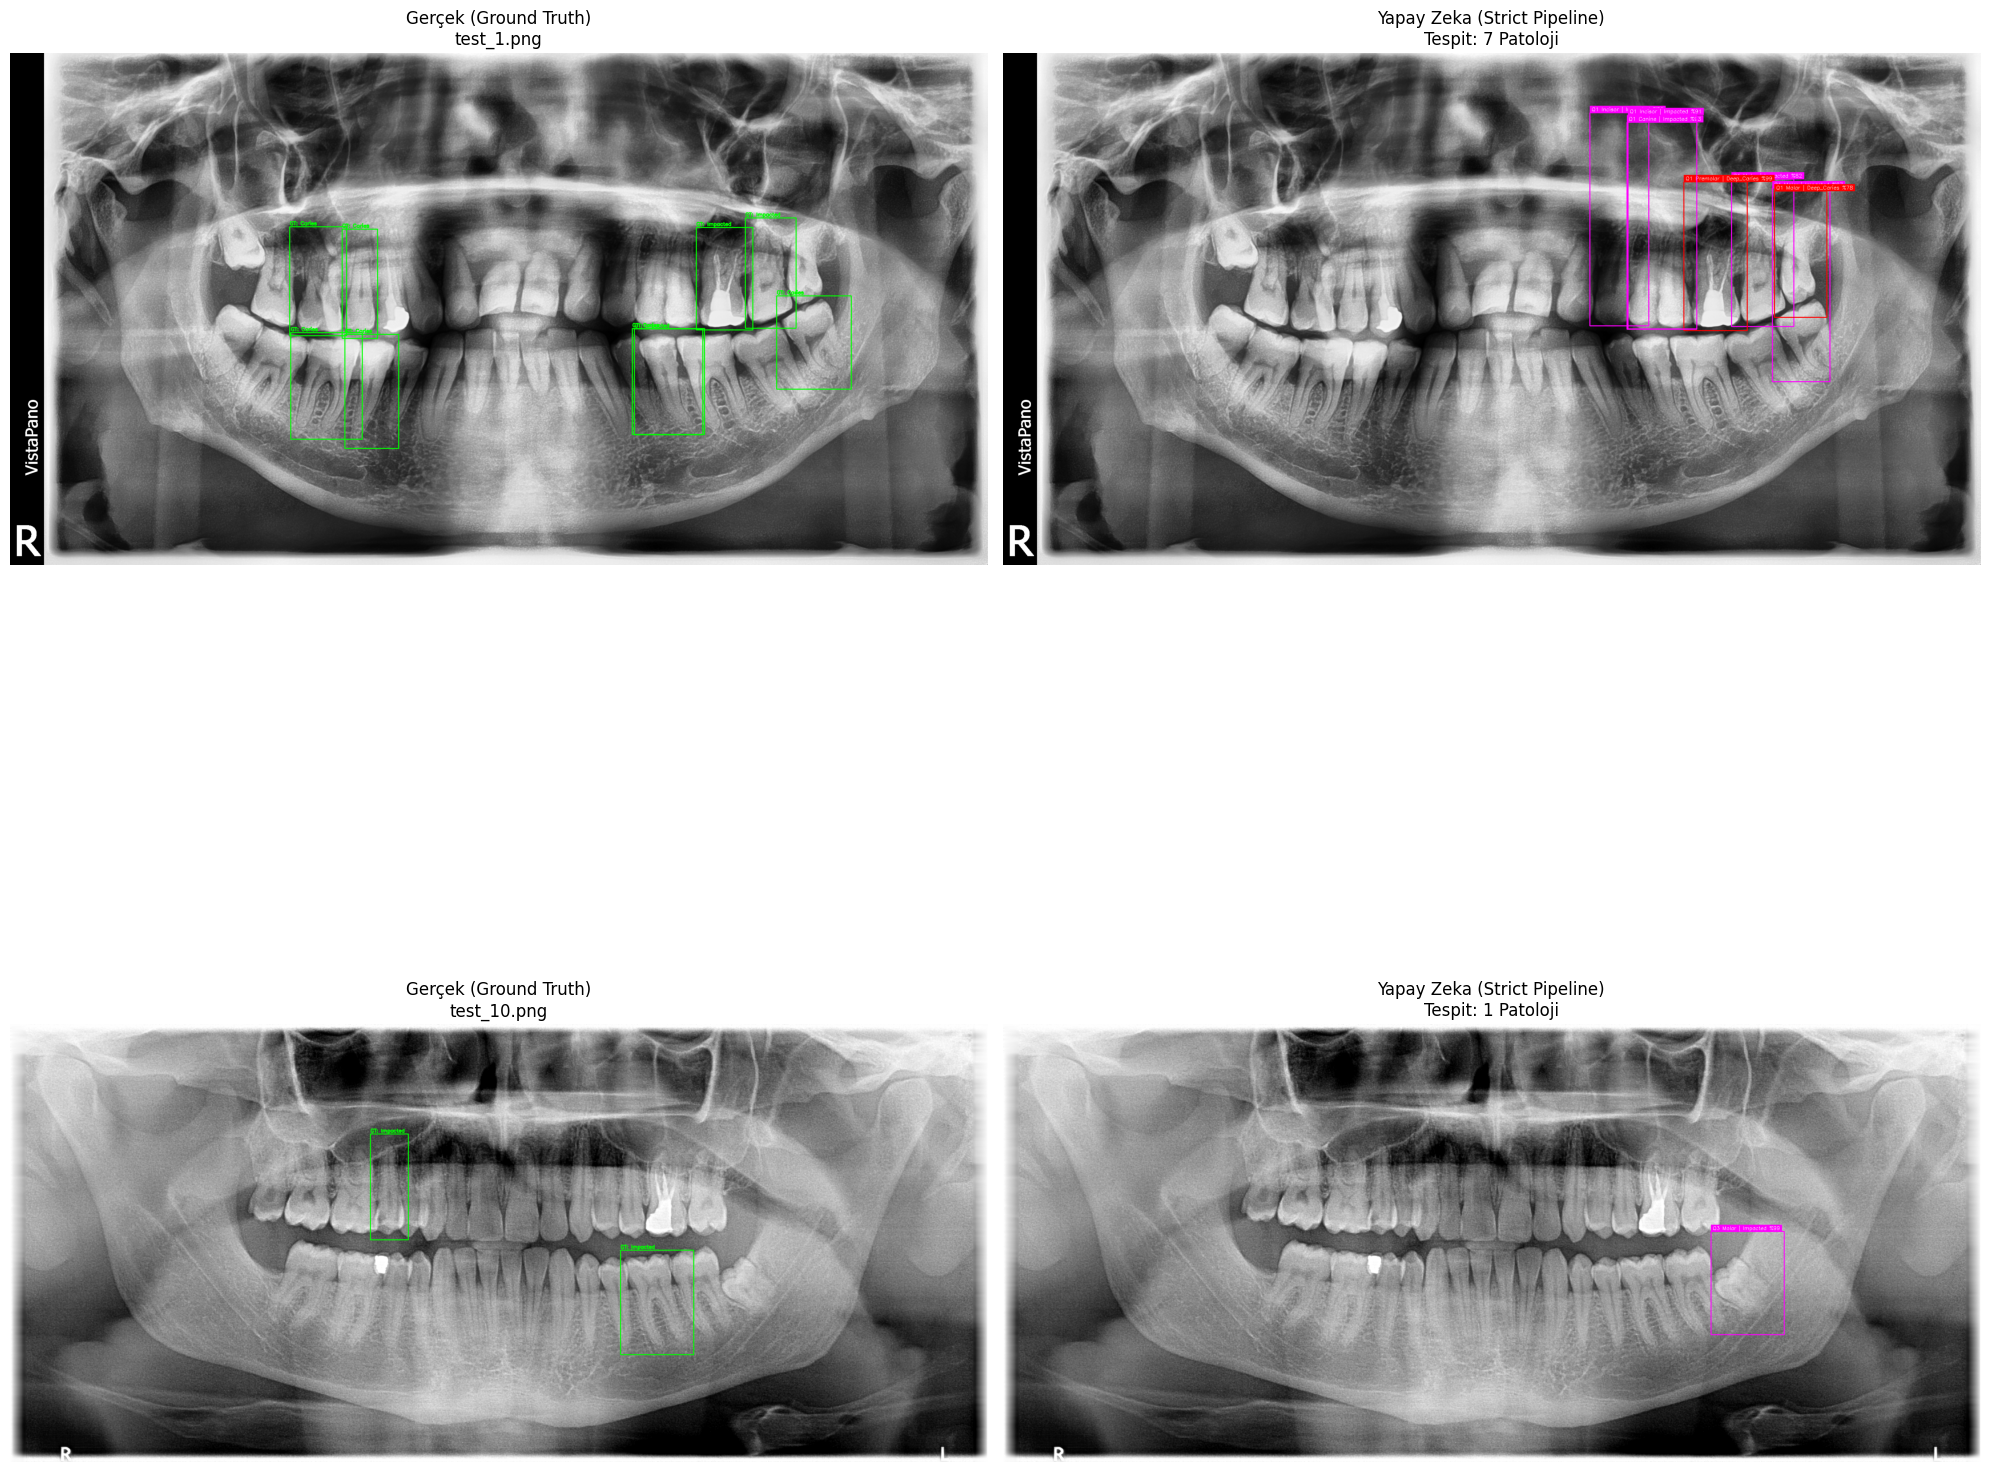

In [9]:
# Test resimlerini bul
test_images = sorted(glob(os.path.join(TEST_IMG_DIR, "*.png")))
print(f"Toplam {len(test_images)} adet test resmi var.")

# Kaç tane gösterelim?
NUM_SAMPLES = 3

plt.figure(figsize=(20, 10 * NUM_SAMPLES))

for i, img_path in enumerate(test_images[1:NUM_SAMPLES]):
    filename = os.path.basename(img_path)
    json_path = os.path.join(TEST_LBL_DIR, filename.replace(".png", ".json"))
    
    # 1. SOL TARAFA: Gerçek Veriyi Çiz
    gt_img = draw_ground_truth(img_path, json_path)
    
    # 2. SAĞ TARAFA: Bizim Pipeline Sonucunu Çiz
    # Buradaki büyüye dikkat et: Sadece 2 satır kod!
    original_img, results = analyze_image(img_path, ai_models)
    pred_img = visualize_results(original_img, results)
    
    # Çizim
    plt.subplot(NUM_SAMPLES, 2, 2*i + 1)
    if gt_img is not None: show_img(gt_img, title=f"Gerçek (Ground Truth)\n{filename}")
    
    plt.subplot(NUM_SAMPLES, 2, 2*i + 2)
    if pred_img is not None: show_img(pred_img, title=f"Yapay Zeka (Strict Pipeline)\nTespit: {len(results)} Patoloji")

plt.tight_layout()
plt.show()